<a href="https://colab.research.google.com/github/datasciencepathways/block8/blob/main/HAR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Video Classification Using Keras**

Credits to Taha Anwar ( BleedAI.com ):

This notebook has used materials from the following sources:

https://learnopencv.com/introduction-to-video-classification-and-human-activity-recognition


Let us create a basic video classification system with Keras. We will first create a normal classifier, then implement a moving average technique and then finally create a Single Frame CNN video classifier.

Here are the steps we will perform:

Step 1: Download and Extract the Dataset

Step 2: Visualize the Data with its Labels

Step 3: Read and Preprocess the Dataset

Step 4: Split the Data into Train and Test Set

Step 5: Construct the Model

Step 6: Compile and Train the Model

Step 7: Plot Model’s Loss and Accuracy Curves

Step 8: Make Predictions with the Model

Step 9: Using Single-Frame CNN Method

Make sure you have pafy, youtube-dl and moviepy packages installed.



In [ ]:
!pip install pafy youtube-dl moviepy

**Import Required Libraries:**

Start by importing all required libraries.


In [3]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Set Numpy, Python and Tensorflow seeds to get consistent results.


In [4]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)


**Step 1: Download and Extract the Dataset**

Let us start by downloading the dataset.

The Dataset we are using is the UCF50 – Action Recognition Dataset.

UCF50 is an action recognition dataset which contains:

50 Action Categories consisting of realistic YouTube videos

25 Groups of Videos per Action Category

133 Average Videos per Action Category

199 Average Number of Frames per Video

320 Average Frames Width per Video

240 Average Frames Height per Video

26 Average Frames Per Seconds per Video

After downloading the data, you will need to extract it.


In [5]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

--2022-07-29 15:30:47--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  93.2MB/s    in 33s     

2022-07-29 15:31:21 (93.5 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



**Step 2: Visualize the Data with its Labels**

Let us pick some random videos from each class of the dataset and display it, this will give us a good overview of how the dataset looks like.


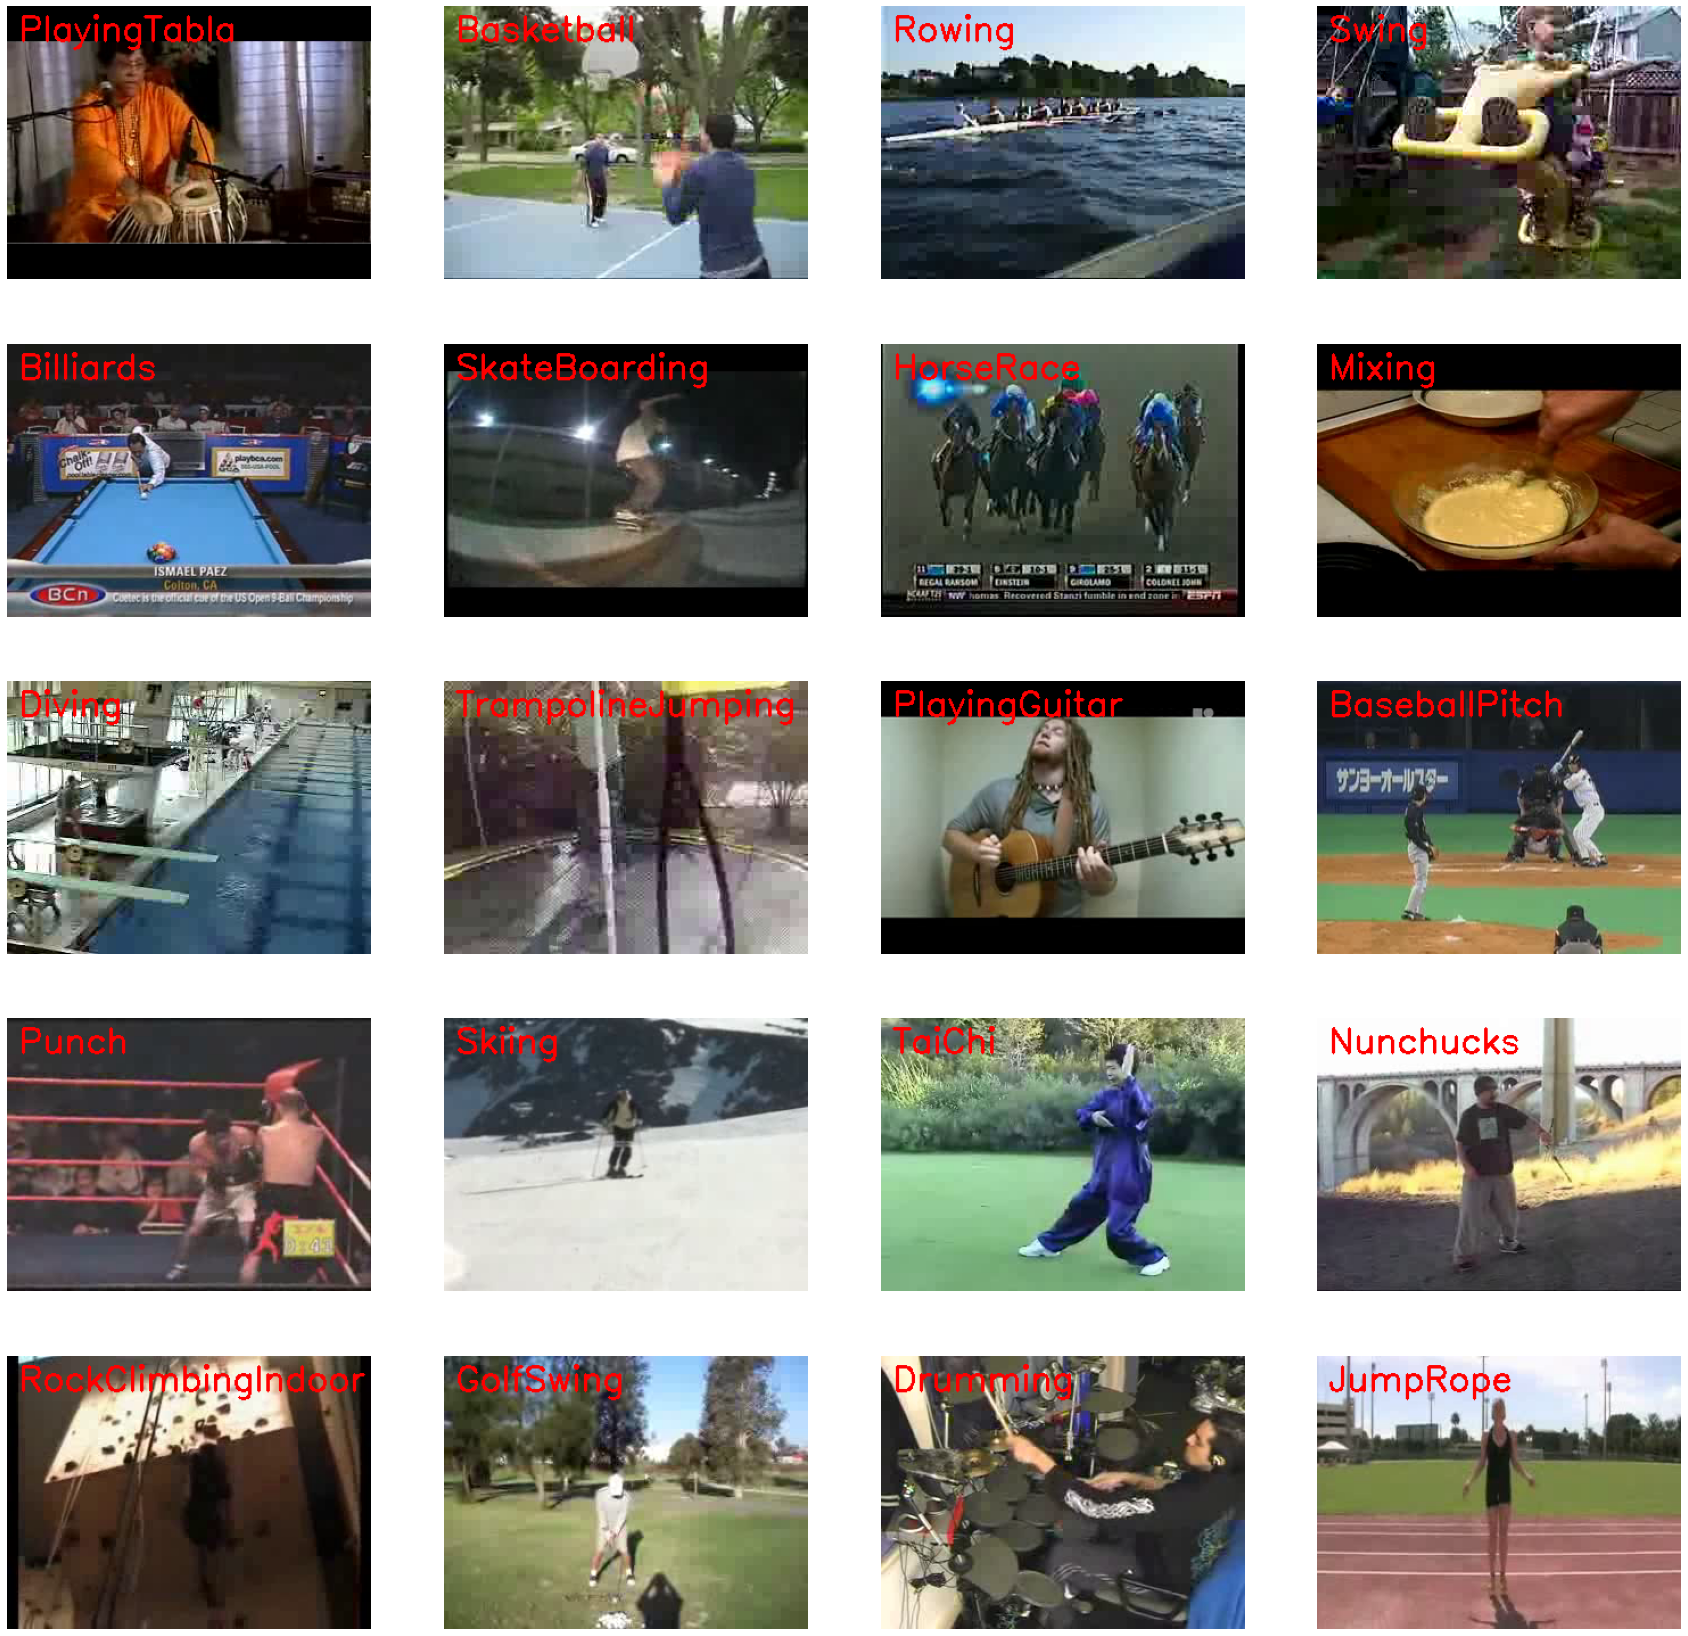

In [6]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = os.listdir('UCF50')

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

**Step 3: Read and Preprocess the Dataset**

Since we are going to use a classification architecture to train on a video classification dataset, we are going to need to preprocess the dataset first.

Now w constants,

image_height and image_weight: This is the size we will resize all frames of the video to, we are doing this to avoid unnecessary computation.

max_images_per_class: Maximum number of training images allowed for each class.

dataset_directory: The path of the directory containing the extracted dataset.

classes_list: These are the list of classes we are going to be training on, we are training on following 4 classes, you can feel free to change it.

tai chi

Swinging

Horse Racing

Walking with a Dog

Note: The image_height, image_weight and max_images_per_class constants may be increased for better results, but be warned this will become computationally expensive.


In [7]:
image_height, image_width = 64, 64
max_images_per_class = 8000

dataset_directory = "UCF50"
classes_list = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

model_output_size = len(classes_list)

**Extract, Resize and Normalize Frames**

Now we will create a function that will extract frames from each video while performing other preprocessing operation like resizing and normalizing images.

This method takes a video file path as input. It then reads the video file frame by frame, resizes each frame, normalizes the resized frame, appends the normalized frame into a list, and then finally returns that list.


In [8]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list
    

**Dataset Creation**

Now we will create another function called create_dataset(), this function uses the frame_extraction() function above and creates our final preprocessed dataset.

Here’s how this function works:

1. Iterate through all the classes mentioned in the classes_list
2. Now for each class iterate through all the video files present in it.
3. Call the frame_extraction method on each video file.
4. Add the returned frames to a list called temp_features
5. After all videos of a class are processed, randomly select video frames (equal to max_images_per_class) and add them to the list called features.
6. Add labels of the selected videos to the `labels` list.
7. After all videos of all classes are processed then return the features and labels as NumPy arrays.

So when you call this function, it returns two lists:

a. A list of feature vectors, and

b. A list of its associated labels.

In [9]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels
    

Calling the create_dataset method which returns features and labels.

In [10]:
features, labels = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


Now we will convert class labels to one hot encoded vectors.

In [11]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

**Step 4: Split the Data into Train and Test Sets**

Now we have two numpy arrays, one containing all images. The second one contains all class labels in one hot encoded format. Let us split our data to create a training, and a testing set. We must shuffle the data before the split, which we have already done.

In [12]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

**Step 5: Construct the Model**

Now it is time to create our CNN model, for this post, we are creating a simple CNN Classification model with two CNN layers.

In [13]:
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

**Check Model’s Structure:**

Using the plot_model function, we can check the structure of the final model. This is really helpful when we are creating a complex network, and you want to make sure we have constructed the network correctly.

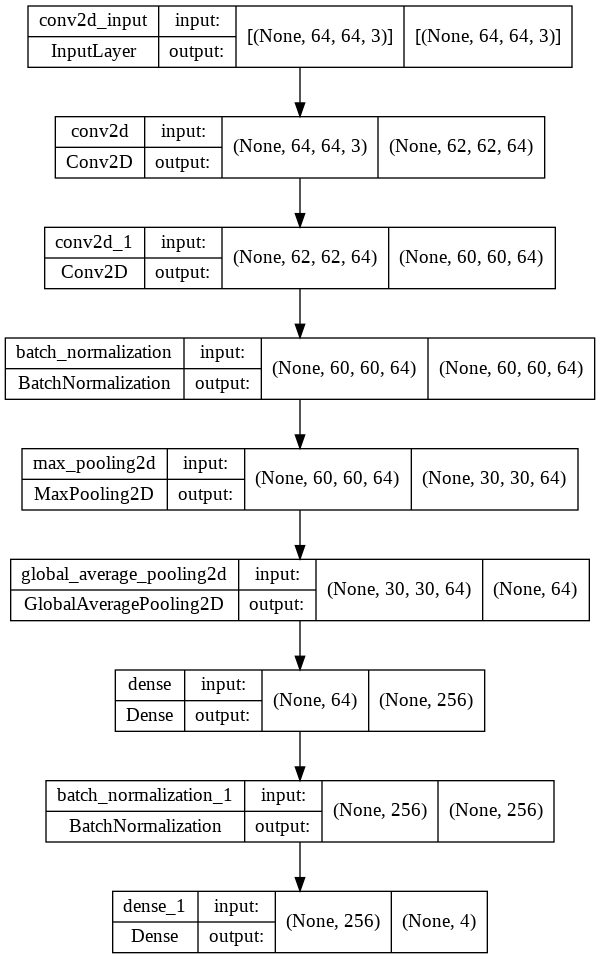

In [14]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

**Step 6: Compile and Train the Model**

Now let us start the training. Before we do that, we also need to compile the model.

In [ ]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
5120/5120 [==============================] - 526s 102ms/step - loss: 0.9065 - accuracy: 0.6308 - val_loss: 0.7284 - val_accuracy: 0.7543
Epoch 2/50
5120/5120 [==============================] - 519s 101ms/step - loss: 0.5369 - accuracy: 0.8032 - val_loss: 0.9348 - val_accuracy: 0.6965
Epoch 3/50
5120/5120 [==============================] - 531s 104ms/step - loss: 0.3859 - accuracy: 0.8644 - val_loss: 0.1247 - val_accuracy: 0.9662
Epoch 4/50
5120/5120 [==============================] - 544s 106ms/step - loss: 0.3234 - accuracy: 0.8874 - val_loss: 0.3888 - val_accuracy: 0.8996
Epoch 5/50
5120/5120 [==============================] - 520s 102ms/step - loss: 0.2835 - accuracy: 0.9017 - val_loss: 1.5243 - val_accuracy: 0.6908
Epoch 6/50
5120/5120 [==============================] - 517s 101ms/step - loss: 0.2485 - accuracy: 0.9152 - val_loss: 0.0799 - val_accuracy: 0.9752
Epoch 7/50
5120/5120 [==============================] - 516s 101ms/step - loss: 0.2472 - accuracy: 0.9155 - val_

**Evaluating Your Trained Model**

Evaluate your trained model on the feature’s and label’s test sets.

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)

**Save Your Model**

You should now save your model for future runs.

In [ ]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)

**Step 7: Plot Model’s Loss and Accuracy Curves**

Let us plot our loss and accuracy curves.

In [ ]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')


**Step 8: Make Predictions with the Model:**

Now that we have created and trained our model it is time to test it is performance on some test videos.

**Function to Download YouTube Videos:**

Let us start by testing on some YouTube videos. This function will use pafy library to download any youtube video and return its title. We just need to pass the URL.

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
    # Creating a Video object which includes useful information regarding the youtube video.
    video = pafy.new(youtube_video_url)

    # Getting the best available quality object for the youtube video.
    video_best = video.getbest()

    # Constructing the Output File Path
    output_file_path = f'{output_directory}/{video.title}.mp4'

    # Downloading the youtube video at the best available quality.
    video_best.download(filepath = output_file_path, quiet = True)

    # Returning Video Title
    return video.title

**Function To Predict on Live Videos Using Moving Average:**

This function will perform predictions on live videos using moving_average. We can either pass in videos saved on disk or use a webcam. If we set window_size hyperparameter to 1, this function will behave like a normal classifier to predict video frames.

**Note:** 
*You can not use your webcam if you are running this notebook on google colab.*

In [ ]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

**Download a Test Video:**

In [ ]:
# Creating The Output directories if it does not exist
output_directory = 'Youtube_Videos'
os.makedirs(output_directory, exist_ok = True)

# Downloading a YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', output_directory)

# Getting the YouTube Video's path you just downloaded
input_video_file_path = f'{output_directory}/{video_title}.mp4'

**Results Without Using Moving Average:**

First let us see the results when we are not using moving average, we can do this by setting the window_size to 1.

In [ ]:
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 1

# Constructing The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)

**Results When Using Moving Average:**

Now let us use moving average with a window size of 25.

Although the results are not perfect but as you can clearly see that it is much better than the previous approach of predicting each frame independently.

In [ ]:
# Setting the Window Size which will be used by the Rolling Average Process
window_size = 25

# Constructing The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction and Rolling Average Process
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)

**Step 9: Using Single-Frame CNN Method:**

Now let us create a function that will output a singular prediction for the complete video. This function will take `n` frames from the entire video and make predictions. In the end, it will average the predictions of those n frames to give us the final activity class for that video. We can set the value of n using the predictions_frames_count variable.

This function is useful when you have a video containing one activity and you want to know the activity’s name and its score.

In [ ]:
def make_average_predictions(video_file_path, predictions_frames_count):
    
    # Initializing the Numpy array which will store Prediction Probabilities
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting The Total Frames present in the video 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating The Number of Frames to skip Before reading a frame
    skip_frames_window = video_frames_count // predictions_frames_count

    for frame_counter in range(predictions_frames_count): 

        # Setting Frame Position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading The Frame
        _ , frame = video_reader.read() 

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

    # Calculating Average of Predicted Labels Probabilities Column Wise 
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Sorting the Averaged Predicted Labels Probabilities
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

    # Iterating Over All Averaged Predicted Label Probabilities
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:

        # Accessing The Class Name using predicted label.
        predicted_class_name = classes_list[predicted_label]

        # Accessing The Averaged Probability using predicted label.
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]

        print(f"CLASS NAME: {predicted_class_name}   AVERAGED PROBABILITY: {(predicted_probability*100):.2}")
    
    # Closing the VideoCapture Object and releasing all resources held by it. 
    video_reader.release()

**Test Average Prediction Method On Youtube Videos:**

In [ ]:
# Downloading The YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=ceRjxW4MpOY', output_directory)

# Constructing The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700)

# Downloading The YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=ayI-e3cJM-0', output_directory)

# Constructing The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700)

# Downloading The YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=XqqpZS0c1K0', output_directory)

# Constructing The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700)

# Downloading The YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=WHBu6iePxKc', output_directory)

# Constructing The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700)

**Summary:**
In this lesson, we learned about video classification and how we can recognize human activity.

Finally we also saw how to build a basic video classification model by leveraging a classification network. Then we implemented moving average to smooth out the predictions.

Finally, we saw how to use the Single-Frame CNN method to average over predictions to give the final activity effectively.